# Import Module

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

from numpy import random
from tensorflow import keras

# Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Path to Drive

In [ ]:
base_path = '/content/drive/My Drive/Colab Notebooks/freshmeat/Meat Freshness/'

In [ ]:
dataset_train = os.path.join(base_path, 'train')
dataset_test = os.path.join(base_path, 'test')
print(os.listdir(dataset_train))
print(os.listdir(dataset_test))

['Fresh', 'Spoiled', 'Half-Fresh']
['Half-Fresh', 'Spoiled', 'Fresh']


# Unpacking Data

In [ ]:
# !unzip '/content/drive/My Drive/Colab Notebooks/freshmeat/archive.zip' -d '/content/drive/My Drive/Colab Notebooks/freshmeat'

# Hapus data yang tidak berguna

In [ ]:
import glob
import shutil

def delete(path):
    if os.path.isfile(path) or os.path.islink(path):
        os.remove(path)
    elif os.path.isdir(path):
        shutil.rmtree(path)
    print('deleted: ' + path)

n = 0
for root, subdir, file in os.walk(dataset_train):
    pattern = os.path.join(root, '.*')
    for path in (glob.glob(pattern)):
        n += 1
        # print(path)
        delete(path)
print(f'{n} hidden file or folder found')

0 hidden file or folder found


# Check invalid data

In [ ]:
from tensorflow.errors import InvalidArgumentError

def check_invalid_image(dataset_dir):
    invalid_images = list()
    for root, subdirs, files in os.walk(dataset_dir):
        for file in files:
            image_path = os.path.join(root, file)
            image = tf.io.read_file(image_path)
            try:
                image = tf.io.decode_image(image,)
            except InvalidArgumentError:
                invalid_images.append(image_path)
    return (invalid_images, len(invalid_images))

data_train = check_invalid_image(dataset_train)
print(data_train)
data_test = check_invalid_image(dataset_test)
print(data_test)

# delete invalid image
for path_file in data_train[0]:
    os.remove(path_file)

for path_file in data_test[0]:
    os.remove(path_file)

([], 0)
([], 0)


# Check image detail

In [ ]:
class_image = os.listdir(dataset_train)
class_image

['Fresh', 'Spoiled', 'Half-Fresh']

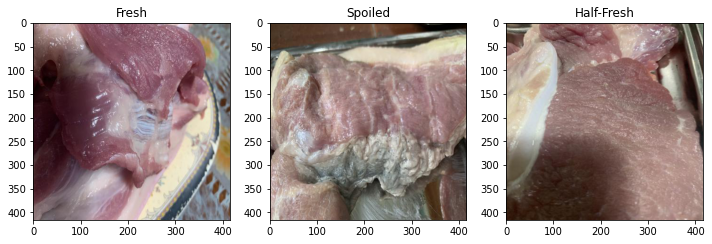

In [ ]:
def get_random_data_perclass():
    random_data_perclass = []

    for root, _, files in os.walk(dataset_train):
        # skip check folder in data_resized
        if len(files) == 0:
            continue
        random_index = random.randint(0, len(files) - 1)
        rand_data_path = os.path.join(root,  files[random_index])
        random_data_perclass.append(rand_data_path)
    return random_data_perclass

# subplot dimension
nrows = 2
ncols = 3

# Index for iterating over images
pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

random_data = get_random_data_perclass()
for i, img_path in enumerate(random_data):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('On')
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(class_image[i])


In [ ]:
def get_all_image_path():
    data = []
    for root, dirs, files in os.walk(dataset_train):
        # skip check folder in data_resized
        if len(files) == 0:
            continue
        for file in files:
            img_path = os.path.join(root, file)
            data.append(img_path)
    return data

# Image Detail

In [ ]:
# image description
n_data = len(get_all_image_path())
print("Number of image data: " + str(n_data))

image = mpimg.imread(random_data[random.randint(0, 3)])
print(f"Image height: {image.shape[0]}")
print(f"Image width: {image.shape[1]}")
print(f"Image channel: {image.ndim}")

Number of image data: 1815
Image height: 416
Image width: 416
Image channel: 3


# number of image per class in train dataset

## Train

In [ ]:
for i, (_, __, files) in enumerate(os.walk(dataset_train)):
    if not files:
        continue
    print(f'{len(files)} images of {class_image[i - 1]}')

675 images of Fresh
510 images of Spoiled
630 images of Half-Fresh


## Test

In [ ]:
for i, (_, __, files) in enumerate(os.walk(dataset_test)):
    if not files:
        continue
    print(f'{len(files)} images of {class_image[i - 1]}')

159 images of Fresh
114 images of Spoiled
178 images of Half-Fresh


# Image Processing

## hyperparameter

In [ ]:
BATCH_SIZE = 100
IMG_HEIGHT = 150
IMG_WIDTH = 150

## load image as tf.dataset

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_train,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode = 'categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_train,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode = 'categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_test,
    label_mode = 'categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 1815 files belonging to 3 classes.
Using 1452 files for training.
Found 1815 files belonging to 3 classes.
Using 363 files for validation.
Found 451 files belonging to 3 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Fresh', 'Half-Fresh', 'Spoiled']


# Show sample image from tf.dataset

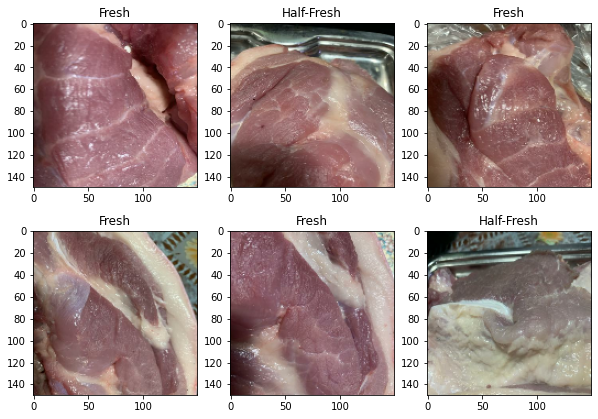

In [ ]:
@tf.function
def ds(data):
    return next(iter(data))

image_batch, label_batch = ds(train_ds)
plt.figure(figsize=(10, 7))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    index_classnames = np.argmax(np.array(label))
    plt.title(class_names[index_classnames])
    plt.axis("on")

# Image Augmentaion

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_HEIGHT, IMG_WIDTH),
    tf.keras.layers.Rescaling(1./255.)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation((-0.3,0.3)),
    tf.keras.layers.RandomZoom((-0.2,0.1)),
    tf.keras.layers.RandomTranslation(0.1,0.1)
])

# Show Resize and Rescaling

In [ ]:
# num_classes = class_name.num_classes
# print(num_classes)

NameError: ignored

In [ ]:
# get_label_name = m.int2str

image, label = next(iter(train_ds))
# _ = plt.imshow(image)
# _ = plt.title(class_names))

In [ ]:
# result = resize_and_rescale(image)
# plt.imshow(result)

# Show Augmentation

In [ ]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

In [ ]:
# plt.figure(figsize=(10, 10))
# for i in range(9):
#   augmented_image = data_augmentation(image)
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(augmented_image[0])
#   plt.axis("off")

# Modelling

## Model Xception

In [ ]:
xception_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
xception_model.trainable = False

In [ ]:
xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_9[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

In [ ]:
model_xception = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    resize_and_rescale,
    data_augmentation,
    xception_model,

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

## Model Inception V3

In [ ]:
inception_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
inception_model.trainable = False

In [ ]:
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_200 (Conv2D)            (None, 74, 74, 32)   864         ['input_11[0][0]']               
                                                                                                  
 batch_normalization_200 (Batch  (None, 74, 74, 32)  96          ['conv2d_200[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [ ]:
model_inception = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    resize_and_rescale,
    data_augmentation,
    inception_model,

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Summary Data

In [ ]:
model_xception.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 sequential_9 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten_4 (Flatten)         (None, 51200)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               6553728   
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 3)               

In [ ]:
model_inception.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 sequential_9 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_5 (Flatten)         (None, 18432)             0         
                                                                 
 dense_15 (Dense)            (None, 128)               2359424   
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 3)               

# Training Data

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_addons as tfa

## Training Model Xception

In [ ]:
model_xception.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=(0.001)),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=3,
                                                  # average='macro',
                                                  threshold=0.5)])

In [ ]:
ACCURACY_THRESHOLD = 0.95
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

In [ ]:
callbacks = myCallback()
history_xception = model_xception.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    callbacks=callbacks,
                    verbose=2
                    )

Epoch 1/50
15/15 - 11s - loss: 2.9313 - accuracy: 0.5138 - precision_4: 0.5235 - recall_4: 0.4993 - f1_score: 0.5217 - val_loss: 0.6582 - val_accuracy: 0.7521 - val_precision_4: 0.7583 - val_recall_4: 0.7521 - val_f1_score: 0.7206 - 11s/epoch - 754ms/step
Epoch 2/50
15/15 - 9s - loss: 0.6822 - accuracy: 0.7293 - precision_4: 0.7325 - recall_4: 0.7225 - f1_score: 0.7367 - val_loss: 0.4482 - val_accuracy: 0.8127 - val_precision_4: 0.8225 - val_recall_4: 0.8044 - val_f1_score: 0.8115 - 9s/epoch - 616ms/step
Epoch 3/50
15/15 - 8s - loss: 0.4834 - accuracy: 0.8037 - precision_4: 0.8068 - recall_4: 0.7996 - f1_score: 0.8103 - val_loss: 0.3042 - val_accuracy: 0.8733 - val_precision_4: 0.8750 - val_recall_4: 0.8678 - val_f1_score: 0.8756 - 8s/epoch - 566ms/step
Epoch 4/50
15/15 - 7s - loss: 0.3690 - accuracy: 0.8375 - precision_4: 0.8414 - recall_4: 0.8333 - f1_score: 0.8446 - val_loss: 0.3159 - val_accuracy: 0.8788 - val_precision_4: 0.8785 - val_recall_4: 0.8760 - val_f1_score: 0.8839 - 7s/e

## Training Model Inception

In [ ]:
model_inception.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=(0.001)),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=3,
                                                  # average='macro',
                                                  threshold=0.5)])

In [ ]:
ACCURACY_THRESHOLD = 0.95
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

In [ ]:
callbacks = myCallback()
history_inception = model_inception.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    callbacks=callbacks,
                    verbose=2
                    )

Epoch 1/50
15/15 - 13s - loss: 7.2066 - accuracy: 0.4167 - precision_5: 0.4155 - recall_5: 0.4015 - f1_score: 0.4079 - val_loss: 1.7155 - val_accuracy: 0.5510 - val_precision_5: 0.5525 - val_recall_5: 0.5510 - val_f1_score: 0.4448 - 13s/epoch - 855ms/step
Epoch 2/50
15/15 - 8s - loss: 0.9423 - accuracy: 0.6405 - precision_5: 0.6525 - recall_5: 0.6233 - f1_score: 0.6499 - val_loss: 0.6794 - val_accuracy: 0.7052 - val_precision_5: 0.7191 - val_recall_5: 0.7052 - val_f1_score: 0.6754 - 8s/epoch - 529ms/step
Epoch 3/50
15/15 - 7s - loss: 0.5317 - accuracy: 0.7569 - precision_5: 0.7721 - recall_5: 0.7445 - f1_score: 0.7671 - val_loss: 0.4376 - val_accuracy: 0.7824 - val_precision_5: 0.7855 - val_recall_5: 0.7769 - val_f1_score: 0.7963 - 7s/epoch - 486ms/step
Epoch 4/50
15/15 - 5s - loss: 0.4707 - accuracy: 0.7858 - precision_5: 0.7990 - recall_5: 0.7693 - f1_score: 0.7938 - val_loss: 0.3760 - val_accuracy: 0.8182 - val_precision_5: 0.8156 - val_recall_5: 0.8044 - val_f1_score: 0.8172 - 5s/e

# Plotting

## Plot Xception

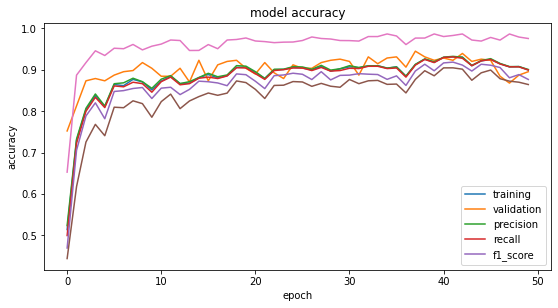

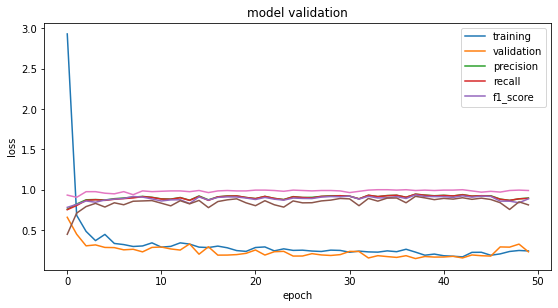

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(history_xception.history['accuracy'])
plt.plot(history_xception.history['val_accuracy'])
plt.plot(history_xception.history['precision_4'])
plt.plot(history_xception.history['recall_4'])
plt.plot(history_xception.history['f1_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation', 'precision', 'recall', 'f1_score'], loc='lower right')

figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(history_xception.history['loss'])
plt.plot(history_xception.history['val_loss'])
plt.plot(history_xception.history['val_precision_4'])
plt.plot(history_xception.history['val_recall_4'])
plt.plot(history_xception.history['val_f1_score'])
plt.title('model validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation', 'precision', 'recall', 'f1_score'], loc='upper right')
plt.show()

## Plot Inception V3

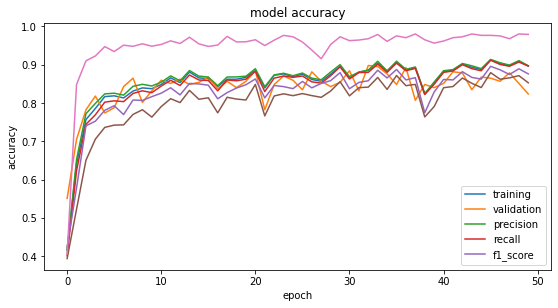

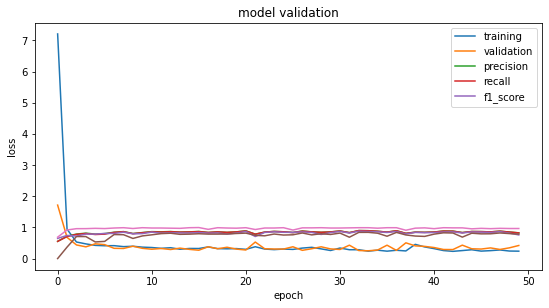

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(history_inception.history['accuracy'])
plt.plot(history_inception.history['val_accuracy'])
plt.plot(history_inception.history['precision_5'])
plt.plot(history_inception.history['recall_5'])
plt.plot(history_inception.history['f1_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation', 'precision', 'recall', 'f1_score'], loc='lower right')

figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(history_inception.history['loss'])
plt.plot(history_inception.history['val_loss'])
plt.plot(history_inception.history['val_precision_5'])
plt.plot(history_inception.history['val_recall_5'])
plt.plot(history_inception.history['val_f1_score'])
plt.title('model validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation', 'precision', 'recall', 'f1_score'], loc='upper right')
plt.show()

# Model Evaluate

In [ ]:
model_xception.evaluate(test_ds)

5/5 [==============================] - 2s 162ms/step - loss: 0.2930 - accuracy: 0.8692 - precision_4: 0.8725 - recall_4: 0.8647 - f1_score: 0.8759


[0.2930315136909485,
 0.8691796064376831,
 0.8724831938743591,
 0.864745020866394,
 array([0.861461  , 0.77490777, 0.99130434], dtype=float32)]

In [ ]:
model_inception.evaluate(test_ds)

5/5 [==============================] - 1s 96ms/step - loss: 0.2970 - accuracy: 0.8714 - precision_5: 0.8714 - recall_5: 0.8714 - f1_score: 0.8828


[0.29700127243995667,
 0.8713968992233276,
 0.8713968992233276,
 0.8713968992233276,
 array([0.8291139, 0.8412257, 0.9779735], dtype=float32)]

# Prediction

Saving spoiled-meat.jpg to spoiled-meat (4).jpg


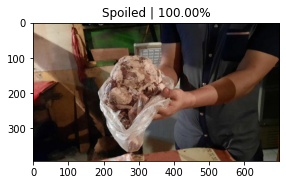

In [ ]:
class_names = train_ds.class_names

import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
i = 0
plt.figure(figsize=(15, 10))
for fn in uploaded.keys():
    img_path = os.path.join('/content', fn)
    img = tf.keras.utils.load_img(
        img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
    )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model_xception.predict(img_array)

    sp = plt.subplot(2, 3, i + 1)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(f"{class_names[np.argmax(predictions[0])]} | {100 * np.max(predictions[0]):.2f}%")

Saving spoiled-meat.jpg to spoiled-meat (5).jpg


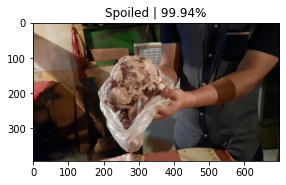

In [ ]:
class_names = train_ds.class_names

import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
i = 0
plt.figure(figsize=(15, 10))
for fn in uploaded.keys():
    img_path = os.path.join('/content', fn)
    img = tf.keras.utils.load_img(
        img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
    )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model_inception.predict(img_array)

    sp = plt.subplot(2, 3, i + 1)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(f"{class_names[np.argmax(predictions[0])]} | {100 * np.max(predictions[0]):.2f}%")

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
# confusion_matrix(train_ds, test_ds)